In [53]:
import numpy as np
import pandas as pd
from pathlib import Path
import hvplot.pandas
%matplotlib inline

# Return Forecasting: Read Historical Daily Yen Futures Data
In this notebook, you will load historical Dollar-Yen exchange rate futures data and apply time series analysis and modeling to determine whether there is any predictable behavior.

In [54]:
# Futures contract on the Yen-dollar exchange rate:
# This is the continuous chain of the futures contracts that are 1 month to expiration
yen_futures = pd.read_csv(
    Path("yen.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1976-08-02,3398.0,3401.0,3398.0,3401.0,NaN,3401.0,2.0,1.0
1976-08-03,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-04,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-05,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-06,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0


In [55]:
# Trim the dataset to begin on January 1st, 1990
yen_futures = yen_futures.loc["1990-01-01":, :]
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1990-01-02,6954.0,6954.0,6835.0,6847.0,NaN,6847.0,48336.0,51473.0
1990-01-03,6877.0,6910.0,6865.0,6887.0,NaN,6887.0,38206.0,53860.0
1990-01-04,6937.0,7030.0,6924.0,7008.0,NaN,7008.0,49649.0,55699.0
1990-01-05,6952.0,6985.0,6942.0,6950.0,NaN,6950.0,29944.0,53111.0
1990-01-08,6936.0,6972.0,6936.0,6959.0,NaN,6959.0,19763.0,52072.0


 # Return Forecasting: Initial Time-Series Plotting

 Start by plotting the "Settle" price. Do you see any patterns, long-term and/or short?

In [56]:
# Plot just the "Settle" column from the dataframe:
yen_futures_plot= yen_futures.hvplot.line( 
    title = "Historic USD-Yen Futures Settle Price",
    xlabel = "Date", ylabel = "Settle",
    y='Settle',
    rot=45,
    legend=False,
    ).opts(
    fontsize={'title': 24, 'labels': 12, 'xticks': 12, 'yticks': 12},
    height=500, width=1200,)
yen_futures_plot

:Curve   [Date]   (Settle)

*Answer*
 * Based on the plot above, we can see a long-term strengthening of the Japanese Yen against the Dollar. There do seem to be some more medium, 1-3 year consistent trends, but on a daily basis, there are a lot of short-term ups and downs.

---

# Decomposition Using a Hodrick-Prescott Filter

 Using a Hodrick-Prescott Filter, decompose the Settle price into a trend and noise.

In [57]:
import statsmodels.api as sm

# Apply the Hodrick-Prescott Filter by decomposing the "Settle" price into two separate series:
yen_noise, yen_trend = sm.tsa.filters.hpfilter(yen_futures['Settle'])

In [58]:
# Create a dataframe of just the settle price, and add columns for "noise" and "trend" series from above:
yen_futures['noise'], yen_futures['trend'] = yen_noise, yen_trend
yen_nt = yen_futures[['Settle', 'noise', 'trend']]
yen_nt.head()

,Settle,noise,trend
Date,,,
1990-01-02,6847.0,-61.503967,6908.503967
1990-01-03,6887.0,-21.799756,6908.799756
1990-01-04,7008.0,98.942896,6909.057104
1990-01-05,6950.0,40.776052,6909.223948
1990-01-08,6959.0,49.689938,6909.310062


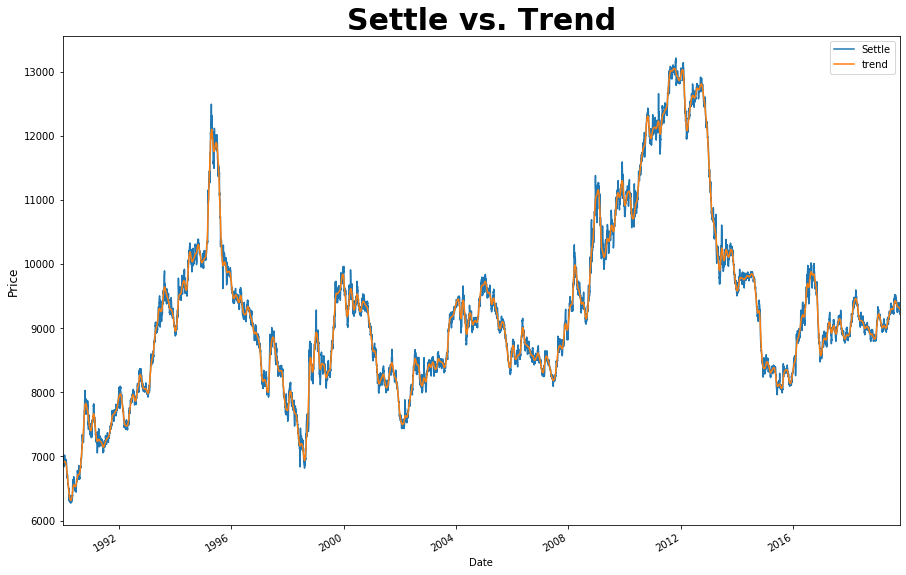

In [59]:
# Plot the Settle Price vs. the Trend
# <yen_st = yen_nt.Settle.hvplot.line(legend=False) * yen_nt.trend.hvplot.line(legend=False)> or <yen_nt.loc[:,['Settle', 'trend']].hvplot.line()> or below
Svt_plot = yen_nt.loc[:,['Settle', 'trend']].plot(title = 'Settle vs. Trend', figsize=(15,10))
Svt_plot.set_ylabel("Price", fontsize = 12)
Svt_plot.title.set_size(30)
Svt_plot.title.set_weight("bold")

Smoothing with the HP Filter and plotting the resulting trend against the actual futures returns, we can see that there's a lot of short term fluctuations that deviate around this trend. Perhaps these would represent profitable trading opportunities: For example, when the blue line deviates far below the orange, we can see this as a sign that the Yen is temporarily more undervalued than it should be (and, therefore, we'd see this as a short-term buying opportunity).

Text(0, 0.5, 'Price')

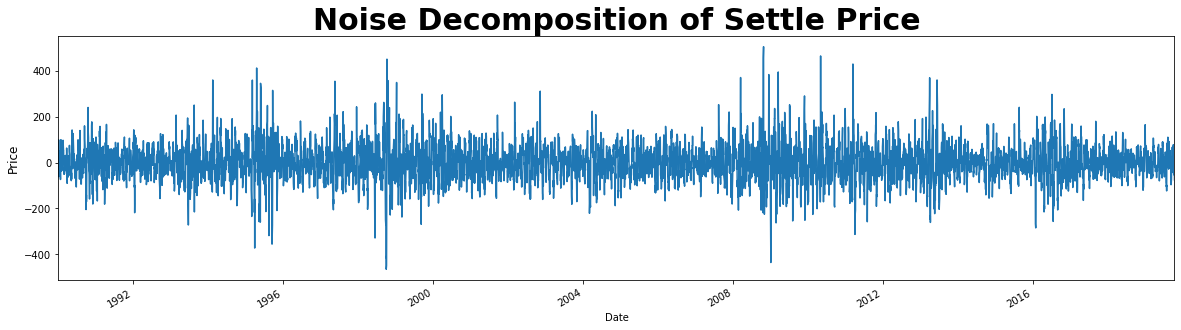

In [60]:
# Plot the Settle Noise
yen_noise_plot = yen_nt.noise.plot(title = 'Noise Decomposition of Settle Price', figsize=(20,5))
yen_noise_plot.title.set_size(30)
yen_noise_plot.title.set_weight("bold")
yen_noise_plot.set_ylabel("Price", fontsize = 12)

---

# Forecasting Returns using an ARMA Model

Using futures Settle *Returns*, estimate an ARMA model

1. ARMA: Create an ARMA model and fit it to the returns data. Note: Set the AR and MA ("p" and "q") parameters to p=2 and q=1: order=(2, 1).
2. Output the ARMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the forecasted returns (the results forecast from ARMA model)

In [61]:
# Create a series using "Settle" price percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s
returns = (yen_futures[["Settle"]].pct_change() * 100)
returns = returns.replace(-np.inf, np.nan).dropna()
# If this next part is not placed before creating the model then an error warning will emerge. This converts it likt .to_frame() and then gives it a frequency
returns.index = pd.DatetimeIndex(returns.index).to_period('D')
returns.tail()

,Settle
Date,
2019-10-09,-0.410601
2019-10-10,-0.369458
2019-10-11,-0.564304
2019-10-14,0.151335
2019-10-15,-0.469509


In [62]:
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA

# Estimate an ARMA model using statsmodels (use order=(2, 1))
model = ARMA(returns.Settle, order=(2,1))

# Fit the model and assign it to a variable called results
results = model.fit()

In [63]:
# Output model summary results:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                 Settle   No. Observations:                 7514
Model:                     ARMA(2, 1)   Log Likelihood               -7894.071
Method:                       css-mle   S.D. of innovations              0.692
Date:                Tue, 26 May 2020   AIC                          15798.142
Time:                        20:50:24   BIC                          15832.765
Sample:                    01-03-1990   HQIC                         15810.030
                         - 10-15-2019                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0063      0.008      0.804      0.422      -0.009       0.022
ar.L1.Settle    -0.3061      1.278     -0.240      0.811      -2.810       2.198
ar.L2.Settle    -0.0019      0.019     -0.099      0.921      -0.040       0.036
ma.L1.Settle     0.2945      1.277      0.231      0.818      -2.209       2.798
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -3.3367           +0.0000j            3.3367            0.5000
AR.2         -157.2692           +0.0000j          157.2692            0.5000
MA.1           -3.3957           +0.0000j            3.3957            0.5000
-----------------------------------------------------------------------------
"""

Text(0.5, 0, 'Days')

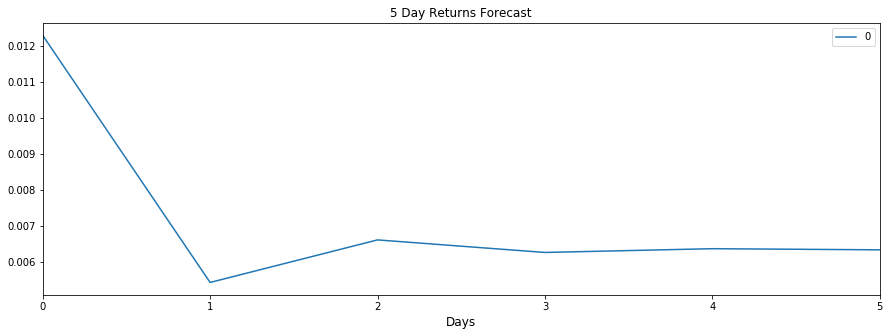

In [64]:
# Plot the 5 Day Returns Forecast
five_day_return = pd.DataFrame(results.forecast(steps=6)[0]).plot(title="5 Day Returns Forecast", figsize=(15,5))
five_day_return.set_xlabel("Days", fontsize=12)

Question: Based on the p-value, is the model a good fit?

Answer:

Based on the the P>|z| column above, this model is not a good fit because All the values in that column are above the given threshold of .05 indicating that perhaps it is using an unreliable coefficient. Therefore, the use of this model may yield unreliable results. 

---

# Forecasting the Settle Price using an ARIMA Model

 1. Using the *raw* Yen **Settle Price**, estimate an ARIMA model.
     1. Set P=5, D=1, and Q=1 in the model (e.g., ARIMA(df, order=(5,1,1))
     2. P= # of Auto-Regressive Lags, D= # of Differences (this is usually =1), Q= # of Moving Average Lags
 2. Output the ARIMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
 3. Construct a 5 day forecast for the Settle Price. What does the model forecast will happen to the Japanese Yen in the near term?

In [65]:
from statsmodels.tsa.arima_model import ARIMA
yen_futures.index = pd.DatetimeIndex(yen_futures.index).to_period('D')

# Estimate and ARIMA Model:
# Hint: ARIMA(df, order=(p, d, q))
model = ARIMA(yen_futures.Settle, order=(5, 1, 1))

# Fit the model
results_ARIMA = model.fit()

In [66]:
# Output model summary results:
results_ARIMA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:               D.Settle   No. Observations:                 7514
Model:                 ARIMA(5, 1, 1)   Log Likelihood              -41944.619
Method:                       css-mle   S.D. of innovations             64.281
Date:                Tue, 26 May 2020   AIC                          83905.238
Time:                        20:50:30   BIC                          83960.635
Sample:                    01-03-1990   HQIC                         83924.259
                         - 10-15-2019                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.3160      0.700      0.452      0.652      -1.056       1.688
ar.L1.D.Settle     0.2824      0.699      0.404      0.686      -1.088       1.652
ar.L2.D.Settle     0.0007      0.016      0.043      0.966      -0.030       0.032
ar.L3.D.Settle    -0.0126      0.012     -1.032      0.302      -0.037       0.011
ar.L4.D.Settle    -0.0137      0.015     -0.889      0.374      -0.044       0.016
ar.L5.D.Settle    -0.0012      0.018     -0.064      0.949      -0.036       0.034
ma.L1.D.Settle    -0.2974      0.699     -0.426      0.670      -1.667       1.072
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.8920           -1.3784j            2.3409           -0.1002
AR.2            1.8920           +1.3784j            2.3409            0.1002
AR.3           -2.2712           -3.0199j            3.7787           -0.3526
AR.4           -2.2712           +3.0199j            3.7787            0.3526
AR.5          -11.1098           -0.0000j           11.1098           -0.5000
MA.1            3.3620           +0.0000j            3.3620            0.0000
-----------------------------------------------------------------------------
"""

Text(0.5, 0, 'Days')

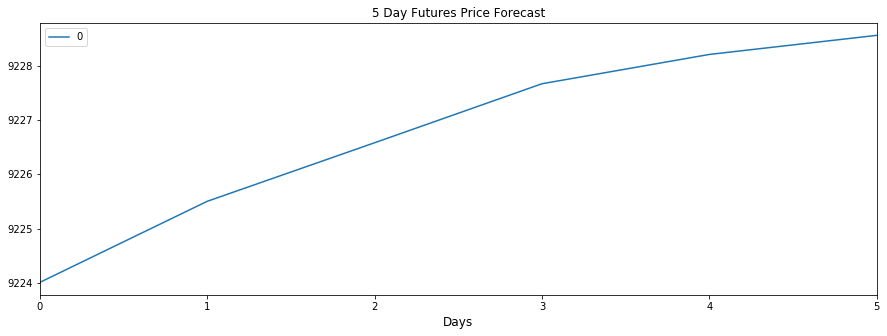

In [67]:
# Plot the 5 Day Price Forecast
five_day_ARIMA = pd.DataFrame(results_ARIMA.forecast(steps=6)[0]).plot(title="5 Day Futures Price Forecast", figsize=(15,5))
five_day_ARIMA.set_xlabel("Days", fontsize=12)

What does the model forecast will happen to the Japanese Yen in the near term?

When the ARIMA model is set to p=5, d= 1, and q=1, the ARIMA model forecasts that the Japanese Yen will increase by 4 in the next 5 days. 

---

# Volatility Forecasting with GARCH

Rather than predicting returns, let's forecast near-term **volatility** of Japanese Yen futures returns. Being able to accurately predict volatility will be extremely useful if we want to trade in derivatives or quantify our maximum loss.
 
Using futures Settle *Returns*, estimate an GARCH model

1. GARCH: Create an GARCH model and fit it to the returns data. Note: Set the parameters to p=2 and q=1: order=(2, 1).
2. Output the GARCH summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the volatility.

In [68]:
import arch as arch
from arch import arch_model


In [69]:
# Estimate a GARCH model:
model = arch_model(returns, mean="Zero", vol="GARCH", p=2, q=1)

# Fit the model
res = model.fit(disp="off")

In [70]:
# Summarize the model results
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:                 Settle   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -7461.93
Distribution:                  Normal   AIC:                           14931.9
Method:            Maximum Likelihood   BIC:                           14959.6
                                        No. Observations:                 7514
Date:                Tue, May 26 2020   Df Residuals:                     7510
Time:                        20:50:47   Df Model:                            4
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      4.2896e-03  2.057e-03      2.085  3.708e-02  [2.571e-04,8.322e-03]
alpha[1]       0.0381  1.282e-02      2.970  2.974e-03  [1.295e-02,6.321e-02]
alpha[2]       0.0000  1.703e-02      0.000      1.000 [-3.338e-02,3.338e-02]
beta[1]        0.9536  1.420e-02     67.135      0.000      [  0.926,  0.981]
=============================================================================

Covariance estimator: robust
"""

In [79]:
# Find the last day of the dataset
last_day = returns.index.max()
last_day 

Period('2019-10-15', 'D')

In [80]:
# Create a 5 day forecast of volatility
forecast_horizon = 5
# Start the forecast using the last_day calculated above
forecasts = res.forecast(start=last_day, horizon=forecast_horizon)
forecasts

In [81]:
# Annualize the forecast
intermediate = np.sqrt(forecasts.variance.dropna() * 252)
intermediate.tail()

,h.1,h.2,h.3,h.4,h.5
Date,,,,,
2019-10-15,7.434048,7.475745,7.516867,7.557426,7.597434


In [82]:
# Transpose the forecast so that it is easier to plot
final = intermediate.dropna().T
final.head()

Date,2019-10-15
h.1,7.434048
h.2,7.475745
h.3,7.516867
h.4,7.557426
h.5,7.597434


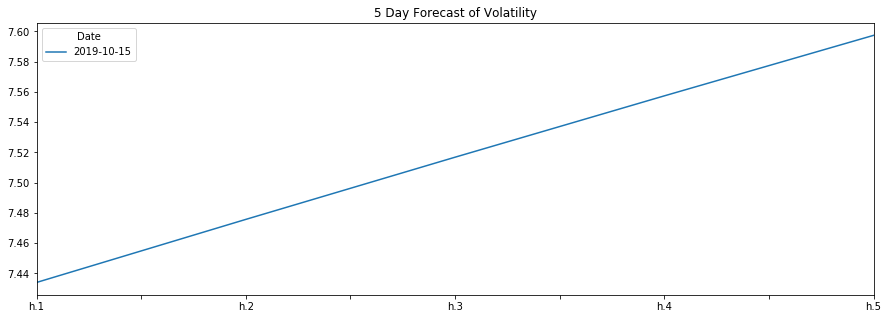

In [83]:
# Plot the final forecast
final.plot(title="5 Day Forecast of Volatility", figsize=(15,5))

---

# Conclusions

Based on your time series analysis, would you buy the yen now?

Is the risk of the yen expected to increase or decrease?

Based on the model evaluation, would you feel confident in using these models for trading?

Based on the model evaluation I would not feel confident in using these models for trading. The reasoning behind this decision is based on the poor p-values that the ARMA and ARIMA models yield. On top of this issue, the GARCH model predicts that the volatility of the yen against the dollar will increase. Therefore, I would not make a decision based on this model. If the models had better statistical performance then I would certaintainly buy considering that the model predicts the yen will appreciate in the next 5 days. 